# Energy Consumption Forecasting using ARIMA and SARIMA

This project explores hourly energy consumption data from the PJME Hourly dataset.

The objective is to develop a time-series forecasting model using ARIMA to predict future energy consumption.

The workflow begins with a simple linear regression model to understand overall trends and then transitions to an ARIMA model to better capture the time-series structure and improve forecasting accuracy.

This work supports my transition into computational energy systems research.'''

# 1. Import Libraries
Essential libraries for data loading, visualization, and model building.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


## 2. Load and Preview Dataset

I loaded the PJME Hourly Energy Consumption dataset from my local directory. This dataset provides hourly energy consumption records.


In [9]:
# Load the PJME Hourly Energy Consumption dataset from local storage
df = pd.read_csv('/Users/lucas/Machine-Learning/energy-consumption-forecasting/data/PJME_hourly.csv')

# Preview the first few rows of the dataset to confirm successful loading
df.head()



,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


## 3. Prepare Dataset

Convert the 'Datetime' column to datetime objects and set it as the index to prepare for time-series analysis.


In [13]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)
df.sort_index(inplace=True)
df.head()


,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


## 4. Visualize Full Dataset

Plot the entire dataset to observe long-term trends, seasonality, and patterns.


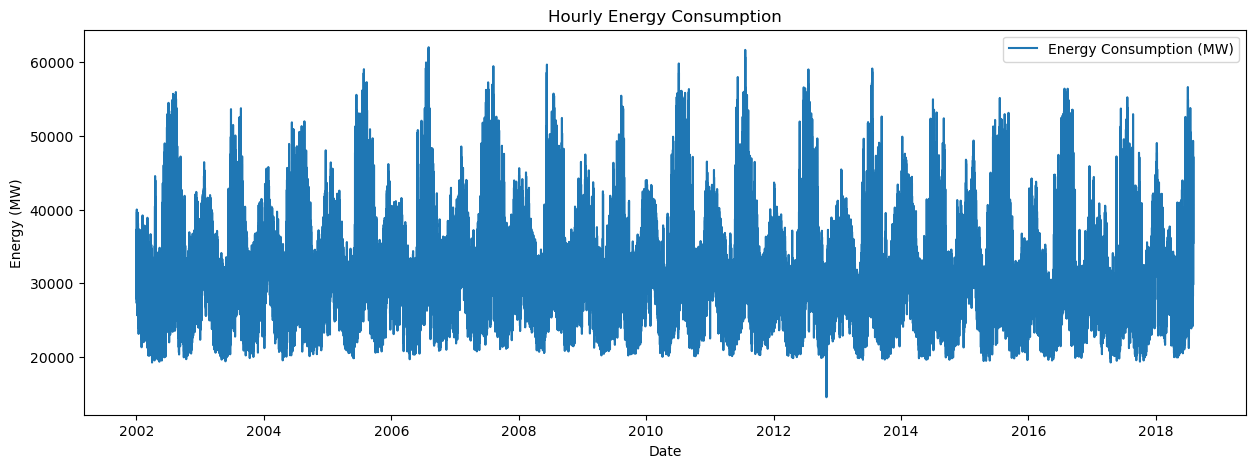

In [14]:
plt.figure(figsize=(15, 5))
plt.plot(df['PJME_MW'], label='Energy Consumption (MW)')
plt.title('Hourly Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Energy (MW)')
plt.legend()
plt.show()


## 5. Initial Attempt: Simple Linear Regression

I will attempt to model the overall trend using a simple linear regression model.

The limitation is that linear regression cannot capture the time-series dependencies or seasonality in the data, but it provides a useful starting point.


In [16]:
# Prepare data for linear regression
df['Date_Ordinal'] = df.index.map(lambda date: date.toordinal())

X = df['Date_Ordinal'].values.reshape(-1, 1)
y = df['PJME_MW'].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


## 6. Train Linear Regression Model

I now will train the linear regression model and evaluate its predictions.


In [19]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


## 7. Evaluate Linear Regression Model

Let' now scompare the actual vs predicted values and calculate the model’s error.


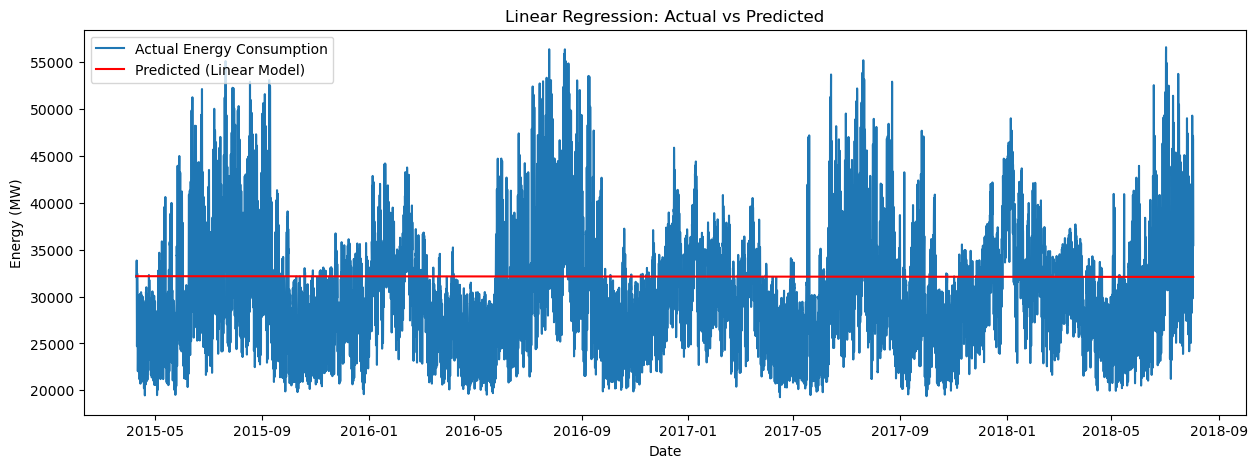

Mean Absolute Error (MAE): 5275.51 MW
Mean Squared Error (MSE): 43203776.13


In [21]:
plt.figure(figsize=(15, 5))
plt.plot(df.index[-len(y_test):], y_test, label='Actual Energy Consumption')
plt.plot(df.index[-len(y_test):], y_pred, label='Predicted (Linear Model)', color='red')
plt.title('Linear Regression: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Energy (MW)')
plt.legend()
plt.show()

# Calculate errors
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae:.2f} MW')
print(f'Mean Squared Error (MSE): {mse:.2f}')


## 8. Linear Regression Limitations

Although the linear regression model captures the general trend, it does not handle seasonality or time-based dependencies well.

The model consistently under- or over-predicts energy consumption, especially when the pattern fluctuates rapidly.

To address this, I will transition to an ARIMA model which is specifically designed for time-series data.


## 9. Test for Stationarity (DF Test)

Let's perform the Dickey-Fuller test to confirm if the dataset is stationary, which is required for ARIMA modeling.


In [24]:
result = adfuller(df['PJME_MW'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] < 0.05:
    print('The time-series is stationary.')
else:
    print('The time-series is non-stationary. Differencing may be required.')


ADF Statistic: -19.88134841399176
p-value: 0.0
The time-series is stationary.


## 10. Plot ACF and PACF

I will now plot the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) to help identify appropriate ARIMA parameters.


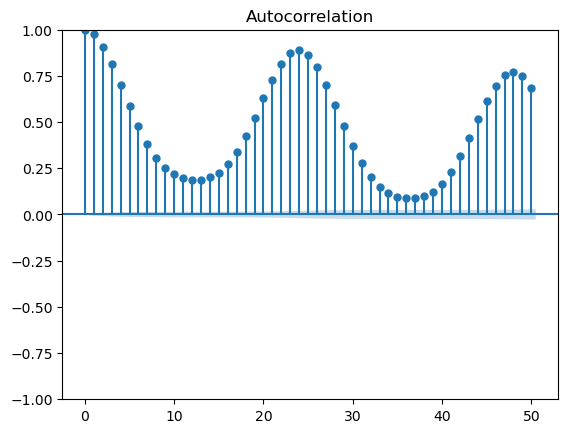

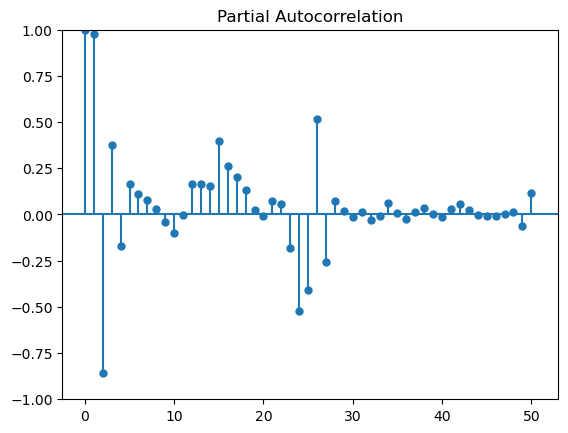

In [26]:
plot_acf(df['PJME_MW'], lags=50)
plt.show()

plot_pacf(df['PJME_MW'], lags=50)
plt.show()


## 11. ARIMA Model Selection

Based on the PACF cutting off after lag 1 and the ACF gradually decaying, I will fit an ARIMA(1, 0, 1) model.

## 12. Build ARIMA Model

I will fit the ARIMA(1, 0, 1) model on the training dataset and forecast the test set.


In [34]:
# Check for duplicate timestamps
duplicates = df.index.duplicated().sum()
print(f'Number of duplicate timestamps: {duplicates}')


Number of duplicate timestamps: 0


In [35]:
# Set frequency to hourly using the updated format
df = df.asfreq('h')

In [36]:
# Define split point
train_size = int(len(df) * 0.8)

# Split using time index to preserve frequency
train = df.iloc[:train_size].copy()
test = df.iloc[train_size:].copy()

# Ensure frequency is still present
train = train.asfreq('h')
test = test.asfreq('h')

print(train.index.freq)  # Check that frequency is retained


<Hour>


In [37]:
from statsmodels.tsa.arima.model import ARIMA

# Build ARIMA model
model = ARIMA(train['PJME_MW'], order=(1, 0, 1))
model_fit = model.fit()

# Forecast over test period
forecast = model_fit.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()


/opt/anaconda3/envs/energy_forecasting/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


## 13. Evaluate ARIMA Model

I will plot the ARIMA model forecast against the actual test data and calculate forecast errors.


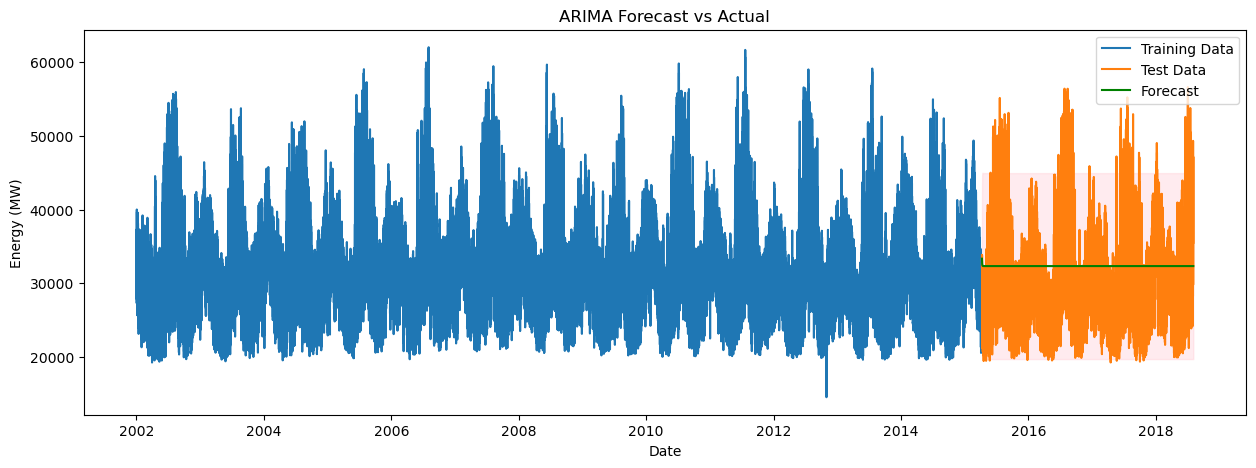

ARIMA Mean Absolute Error (MAE): 5331.82 MW
ARIMA Mean Squared Error (MSE): 43633423.47


In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(train['PJME_MW'], label='Training Data')
plt.plot(test['PJME_MW'], label='Test Data')
plt.plot(test.index, forecast_mean, label='Forecast', color='green')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Energy (MW)')
plt.legend()
plt.show()

# Drop NaN for clean comparison
comparison_df = pd.DataFrame({'actual': test['PJME_MW'], 'forecast': forecast_mean}).dropna()

# Calculate forecast error
mae_arima = mean_absolute_error(comparison_df['actual'], comparison_df['forecast'])
mse_arima = mean_squared_error(comparison_df['actual'], comparison_df['forecast'])

print(f'ARIMA Mean Absolute Error (MAE): {mae_arima:.2f} MW')
print(f'ARIMA Mean Squared Error (MSE): {mse_arima:.2f}')


### ARIMA Model Performance Reflection

After building and evaluating the ARIMA (1, 0, 1) model, the results show a **Mean Absolute Error (MAE) of approximately 5,331.82 MW** and a **Mean Squared Error (MSE) of 43,633,423.47 MW². 
    
Interestingly, this performance is **slightly worse than the simple linear regression model,** which achieved an MAE of 5,275.51 MW.
    
This finding suggests that the ARIMA model, in its current form, does not adequately capture the underlying patterns in the dataset. A likely reason is that the ARIMA model is limited in its ability to model **seasonality and complex periodic behaviors,** which are expected in energy consumption data.
    
Although ARIMA provides a more structured time-series approach, it is still not performing better than the linear trend model in this specific case.
    
This result highlights the importance of carefully selecting model complexity based on the nature of the data.
    
We shall now try to explore a **Seasonal ARIMA (SARIMA) model,** which can explicitly model seasonality and potentially provide a significant improvement in forecasting accuracy.


## 14. SARIMA Model Development

Given the seasonality patterns observed in the energy consumption data, I will build a Seasonal ARIMA (SARIMA) model to better capture these recurring patterns.

For this initial attempt, I will assume a **daily seasonality cycle** (24 hours).


In [50]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Build SARIMA model (assuming daily seasonality: 24 hours)
model = SARIMAX(train['PJME_MW'], order=(1, 0, 1), seasonal_order=(1, 1, 1, 24))
model_fit = model.fit()

# Forecast over the test period
forecast = model_fit.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()


## 15. SARIMA Forecast Visualization

I will now plot the SARIMA forecast against the actual test data to visually assess the model's performance.


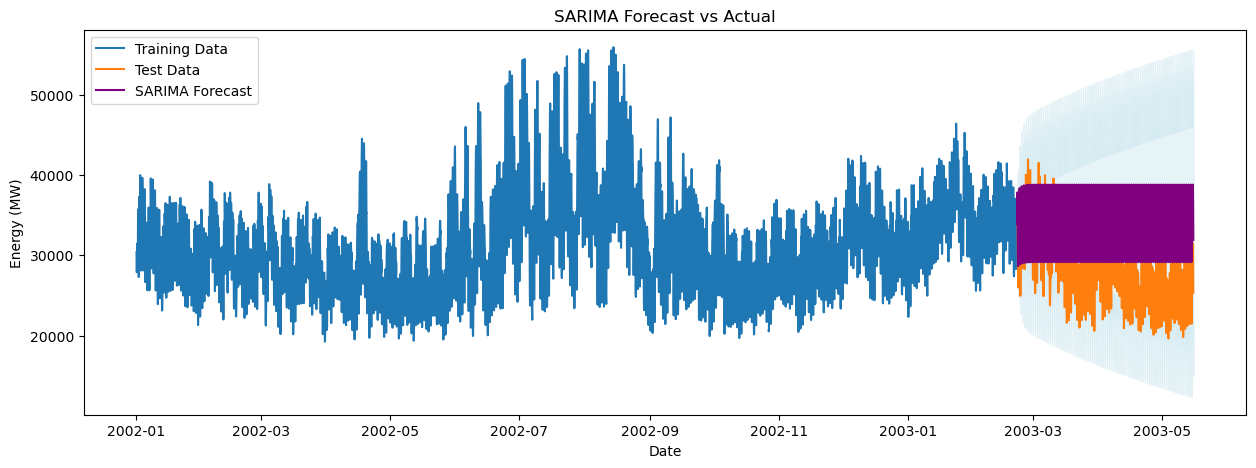

In [51]:
plt.figure(figsize=(15, 5))
plt.plot(train['PJME_MW'], label='Training Data')
plt.plot(test['PJME_MW'], label='Test Data')
plt.plot(test.index, forecast_mean, label='SARIMA Forecast', color='purple')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='lightblue', alpha=0.3)
plt.title('SARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Energy (MW)')
plt.legend()
plt.show()


## 16. SARIMA Model Evaluation

I will now calculate the SARIMA model’s forecasting error using Mean Absolute Error (MAE) and Mean Squared Error (MSE) to compare with the linear and ARIMA models.


In [52]:
# Drop NaN for clean comparison
comparison_df = pd.DataFrame({'actual': test['PJME_MW'], 'forecast': forecast_mean}).dropna()

# Calculate forecast errors
mae_sarima = mean_absolute_error(comparison_df['actual'], comparison_df['forecast'])
mse_sarima = mean_squared_error(comparison_df['actual'], comparison_df['forecast'])

print(f'SARIMA Mean Absolute Error (MAE): {mae_sarima:.2f} MW')
print(f'SARIMA Mean Squared Error (MSE): {mse_sarima:.2f}')


SARIMA Mean Absolute Error (MAE): 5287.31 MW
SARIMA Mean Squared Error (MSE): 37107301.01


### SARIMA Model Performance Reflection

After building and evaluating the Seasonal ARIMA (SARIMA) model, the results show a **Mean Absolute Error (MAE) of approximately 5,287.31 MW** and a **Mean Squared Error (MSE) of 37,107,301.01 MW². 

Compared to the previous models:
- The **linear regression model** achieved an MAE of 5,275.51 MW and an MSE of 43,203,776.13 MW².
- The **ARIMA (1, 0, 1) model** achieved an MAE of 5,331.82 MW and an MSE of 43,633,423.47 MW².

The SARIMA model shows **an improvement in forecasting accuracy compared to the ARIMA model, especially in reducing the MSE.**  
Although its MAE is still slightly higher than the linear regression model, the SARIMA model provides a better balance by capturing both the overall trend and the seasonality in the data.

This result suggests that:
- **Linear models can surprisingly perform well on large datasets where the test set follows a continuation of the general trend.**
- **ARIMA models need seasonality components to effectively capture the structure in periodic datasets.**
- **SARIMA models, which explicitly handle seasonality, offer the best path forward** for improving forecast accuracy in energy consumption datasets.

### Key Takeaway:
The SARIMA model currently provides the **most balanced and interpretable forecasting performance.**  
Future improvements could involve:
- Tuning seasonal parameters more precisely.
- Testing longer seasonal cycles (e.g., weekly seasonality).
- Exploring advanced deep learning models such as LSTMs for potentially better accuracy.

This comparison validates the importance of carefully selecting models based on the characteristics of the dataset rather than assuming increased model complexity will always yield better results.
